# Data Science Project: Predict who is more influential in social network


#### Connect the notebook to Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd

# Hide some unnecessary warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import decomposition

from sklearn import metrics

In [ ]:
root_dir = "drive/MyDrive/Colab Notebooks/predict-who-is-more-influential-in-a-social-network/"

# Dataset: Influencers in Social Networks

## Dataset Description
The dataset, provided by Peerindex, comprises a standard, pair-wise preference learning task. Each datapoint describes two individuals. Pre-computed, standardised features based on twitter activity (such as volume of interactions, number of followers, etc) is provided for each individual.

The discrete label represents a human judgement about which one of the two individuals is more influential. The goal of the challenge is to train a machine learning model which, for a pair of individuals, predicts the human judgement on who is more influential with high accuracy


In [ ]:
!pwd
!ls "/content/drive/MyDrive/Colab Notebooks/predict-who-is-more-influential-in-a-social-network/"

/content
sample_predictions.csv	submission.csv	test.csv  train.csv


In [ ]:
# Set up the random seed for consistency
seed = 12345

# Read files
train = pd.read_csv(root_dir + '/train.csv')
test = pd.read_csv(root_dir + '/test.csv')
submission = pd.read_csv(root_dir + '/sample_predictions.csv')

In [130]:
# List set of all attributes in the dataset
# Features: the rest
# Target: Choice

# Check the datatypes in each column of training set
print(train.dtypes)

# View first 10 rows of the given dataset
print(train.head(10))

print("Training set: ", train.shape)
print("Test set: ", test.shape)
# View the summary of the training set
train.describe()

Choice                   int64
A_follower_count         int64
A_following_count        int64
A_listed_count           int64
A_mentions_received    float64
A_retweets_received    float64
A_mentions_sent        float64
A_retweets_sent        float64
A_posts                float64
A_network_feature_1      int64
A_network_feature_2    float64
A_network_feature_3    float64
B_follower_count         int64
B_following_count        int64
B_listed_count           int64
B_mentions_received    float64
B_retweets_received    float64
B_mentions_sent        float64
B_retweets_sent        float64
B_posts                float64
B_network_feature_1      int64
B_network_feature_2    float64
B_network_feature_3    float64
dtype: object
   Choice  A_follower_count  ...  B_network_feature_2  B_network_feature_3
0       0               228  ...            75.530303          1916.893939
1       0             21591  ...           132.030675          2931.515337
2       0              7310  ...            10.3

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
count,5368.000000,5.368000e+03,5.368000e+03,5368.000000,5.368000e+03,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000,5.368000e+03,5368.000000,5368.000000,5.368000e+03,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000
mean,0.509687,6.531546e+05,1.268433e+04,5964.257452,2.703850e+03,1044.594283,6.010116,1.110900,9.034317,5307.927906,84.925421,3754.398970,6.873185e+05,12652.984911,5914.551043,2.591819e+03,1008.857731,6.111806,1.106489,9.477078,5306.139158,84.856233,3752.620368
std,0.499953,2.042057e+06,4.891607e+04,17492.766722,2.951678e+04,11084.712394,9.533824,1.916878,18.225719,29259.930714,104.056527,5781.096696,2.162965e+06,49856.067279,16417.448299,2.538935e+04,9450.741429,9.755998,1.942058,19.317847,27063.933568,106.277355,5557.683473
min,0.000000,1.600000e+01,0.000000e+00,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000,2.000000e+01,0.000000,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000
25%,0.000000,2.687750e+03,3.217500e+02,85.000000,3.453649e+00,0.716816,0.359534,0.100503,0.625805,12.000000,14.991870,1180.805341,2.573000e+03,322.000000,78.000000,3.277718e+00,0.716251,0.356943,0.100503,0.822584,11.000000,15.176568,1206.500000
50%,1.000000,4.558900e+04,7.790000e+02,932.000000,4.876542e+01,14.029113,2.291802,0.341936,3.467754,195.000000,54.925234,2206.420734,4.402700e+04,771.000000,890.000000,4.853027e+01,14.029113,2.251398,0.341936,3.342999,190.000000,54.925234,2214.125820
75%,1.000000,3.927380e+05,2.838000e+03,6734.000000,3.498196e+02,118.704407,7.049859,1.320681,10.600502,1323.000000,109.695652,4390.379310,3.927380e+05,2838.000000,6734.000000,3.743699e+02,107.081021,6.946233,1.318140,10.600502,1323.000000,109.728261,4345.216686
max,1.000000,3.654319e+07,1.165830e+06,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1121.000000,144651.461538,3.654319e+07,664324.000000,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1861.583333,75526.083333


(array([-5000000.,        0.,  5000000., 10000000., 15000000., 20000000.,
        25000000., 30000000., 35000000., 40000000.]),
 <a list of 10 Text major ticklabel objects>)

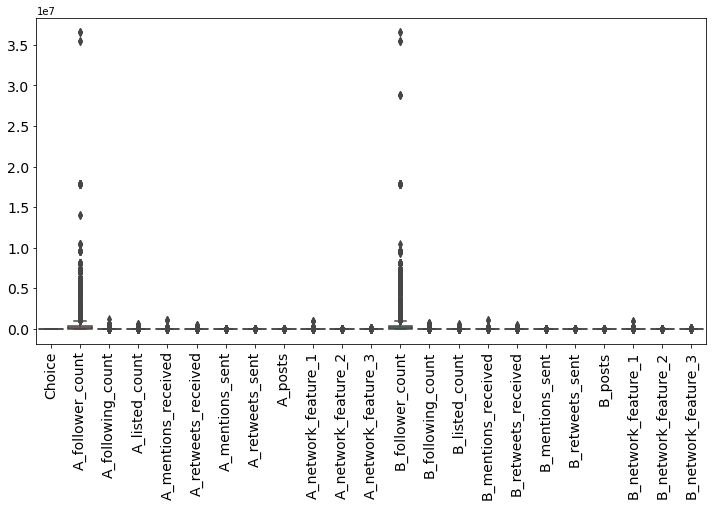

In [131]:
# Creating the boxplot to demonstrate that there is wide range of outliers in each attr
fig1, ax1 = plt.subplots(figsize=(12,6))

sns.boxplot(data=train, ax=ax1)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)

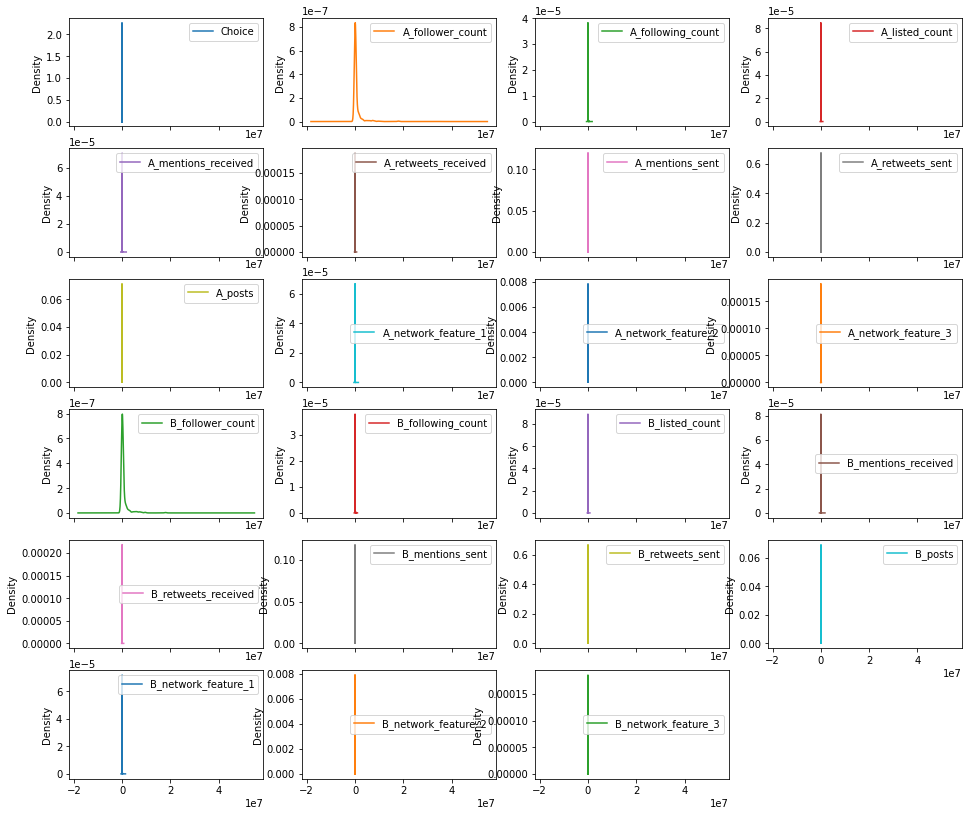

In [134]:
train.plot(kind='density', subplots=True, layout=(6,4), figsize=(16,14))
plt.show()

To view how each attribute of the training data is distributed, we use the pairplot to illustrate the distribution of each attribute corresponding to 2 target classes(0 and 1) where Class 0 is represented in blue, and Class 1 in orange, respectively.

We will show the scatter plot of attributes corresponding to User A(column 1-column 12), and user B(column 13- column 23). The visualisation illustrates that the majority of attributes are distributed in the form of **Exponential Distribution**.

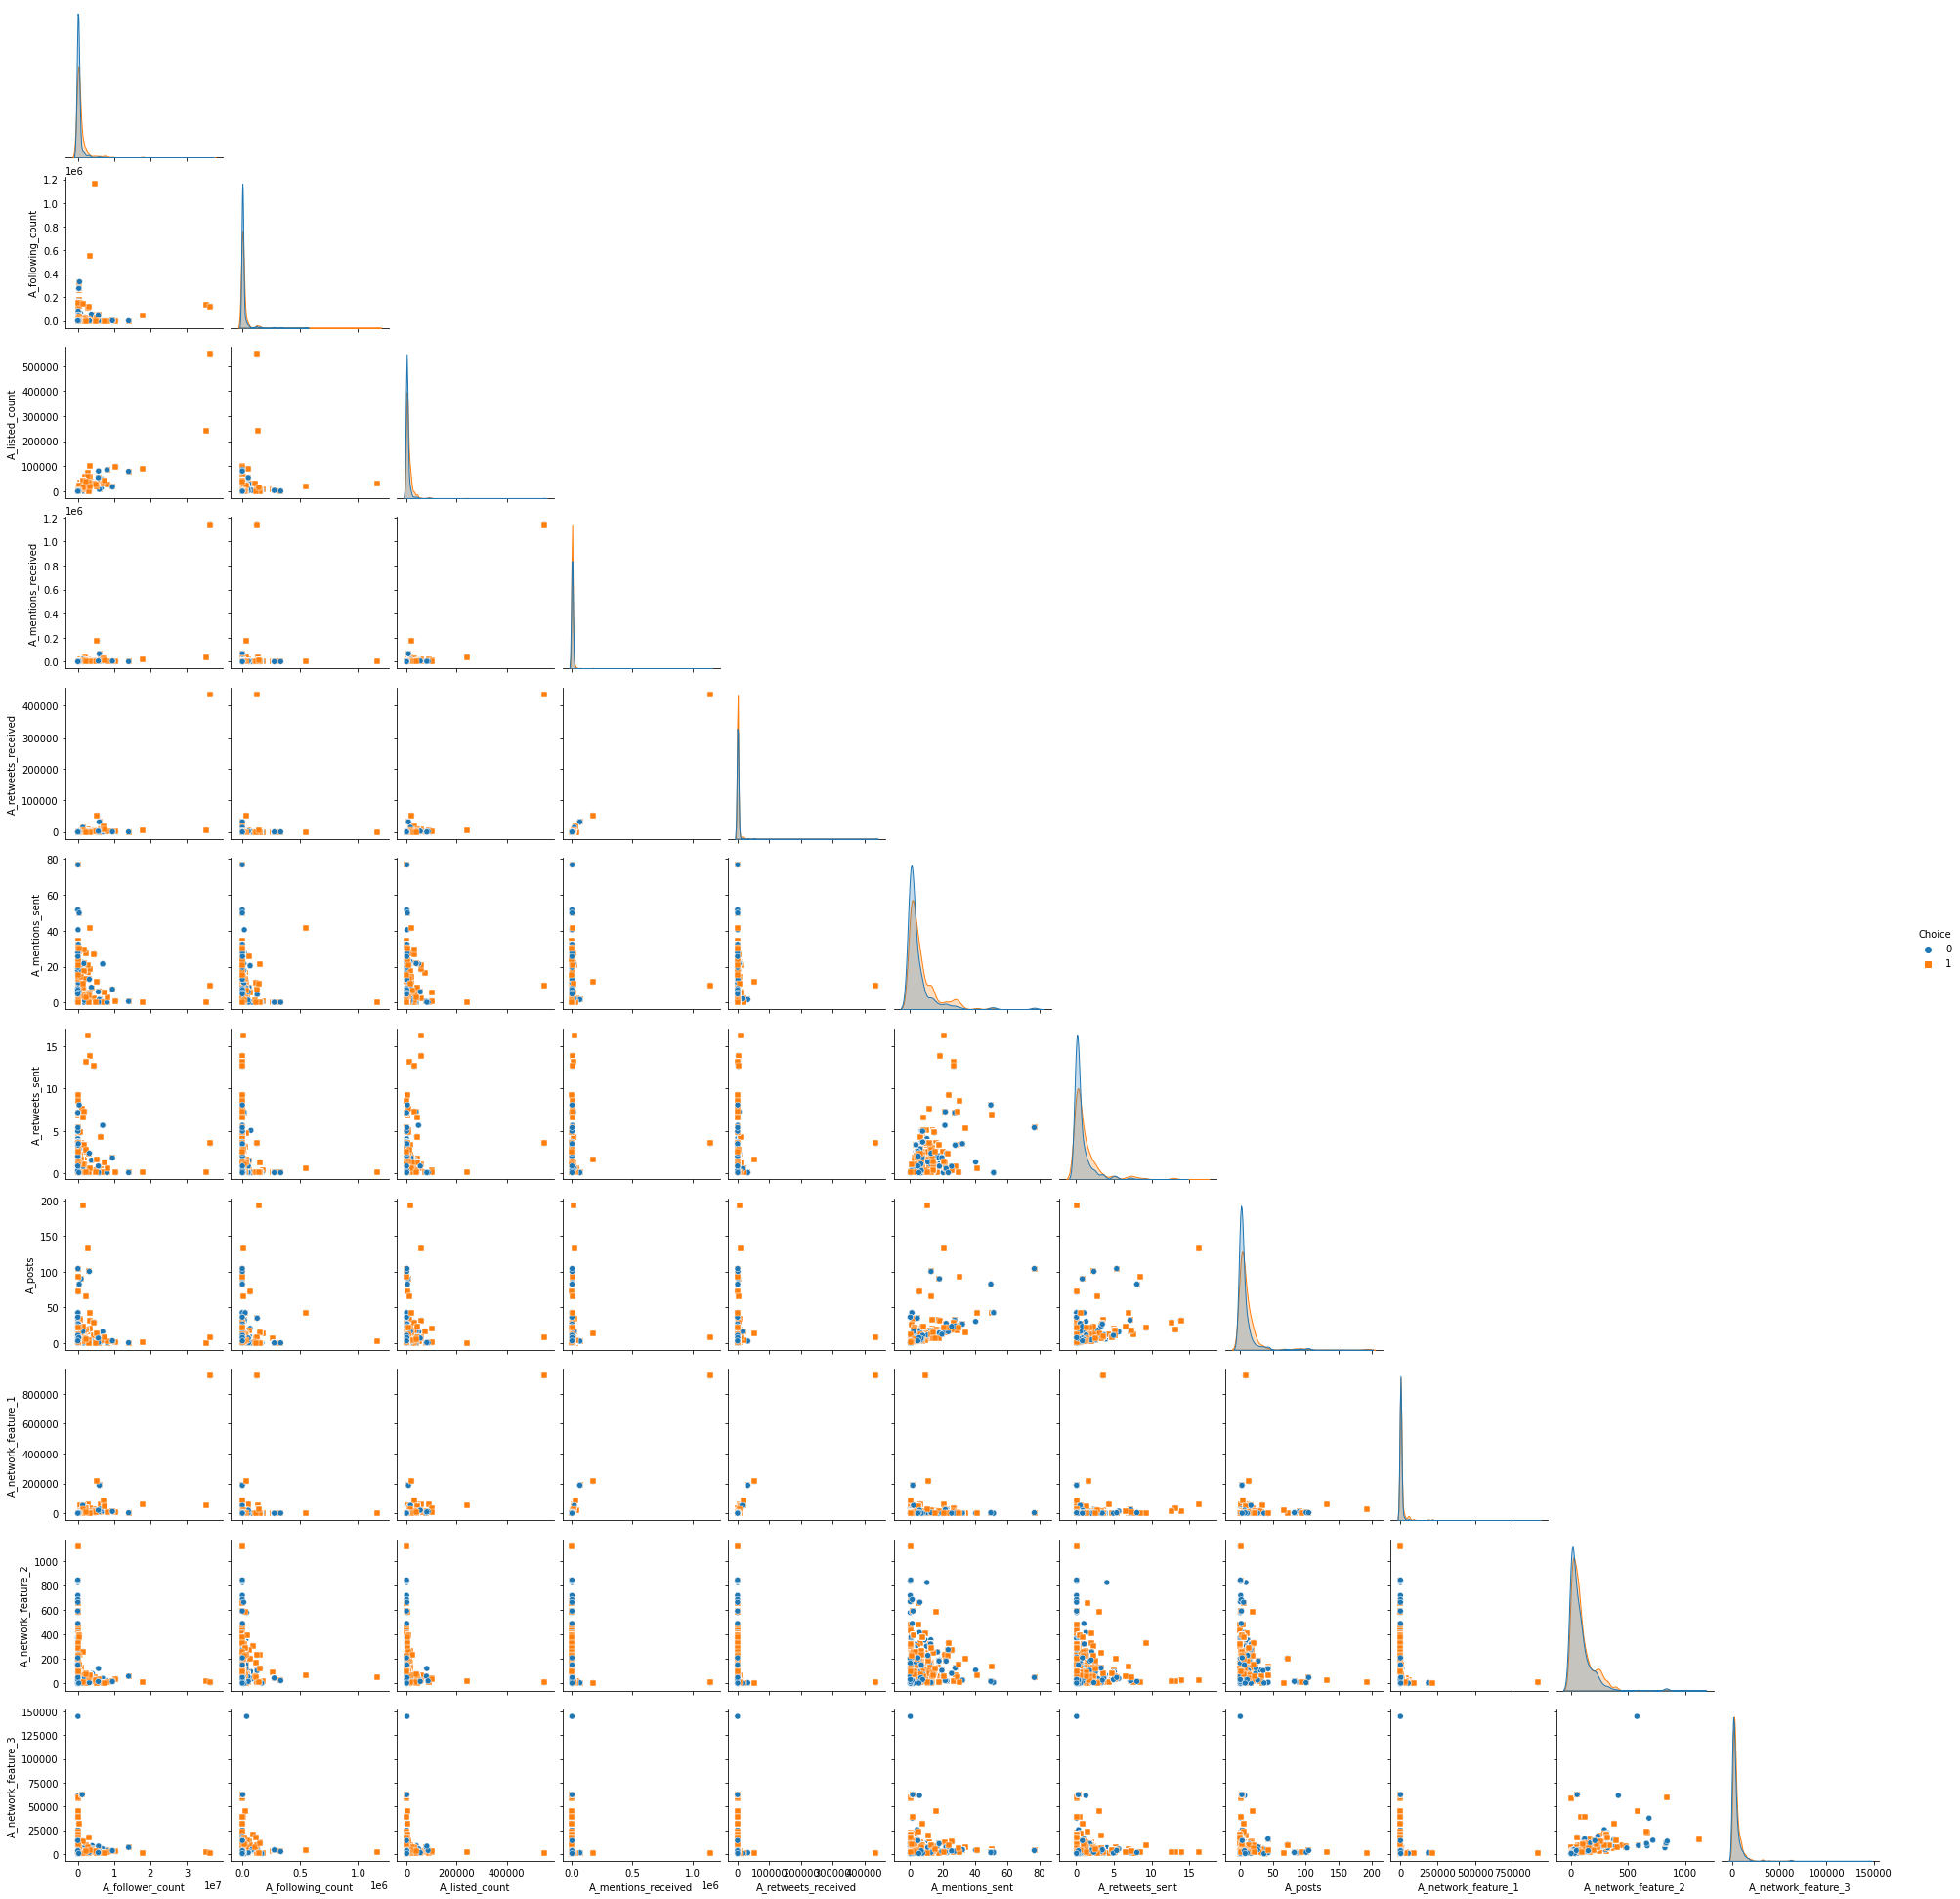

In [62]:
#Scatter plot for person A
sns.pairplot(train.iloc[:,:12], hue="Choice", markers=["o", "s"] , corner=True)

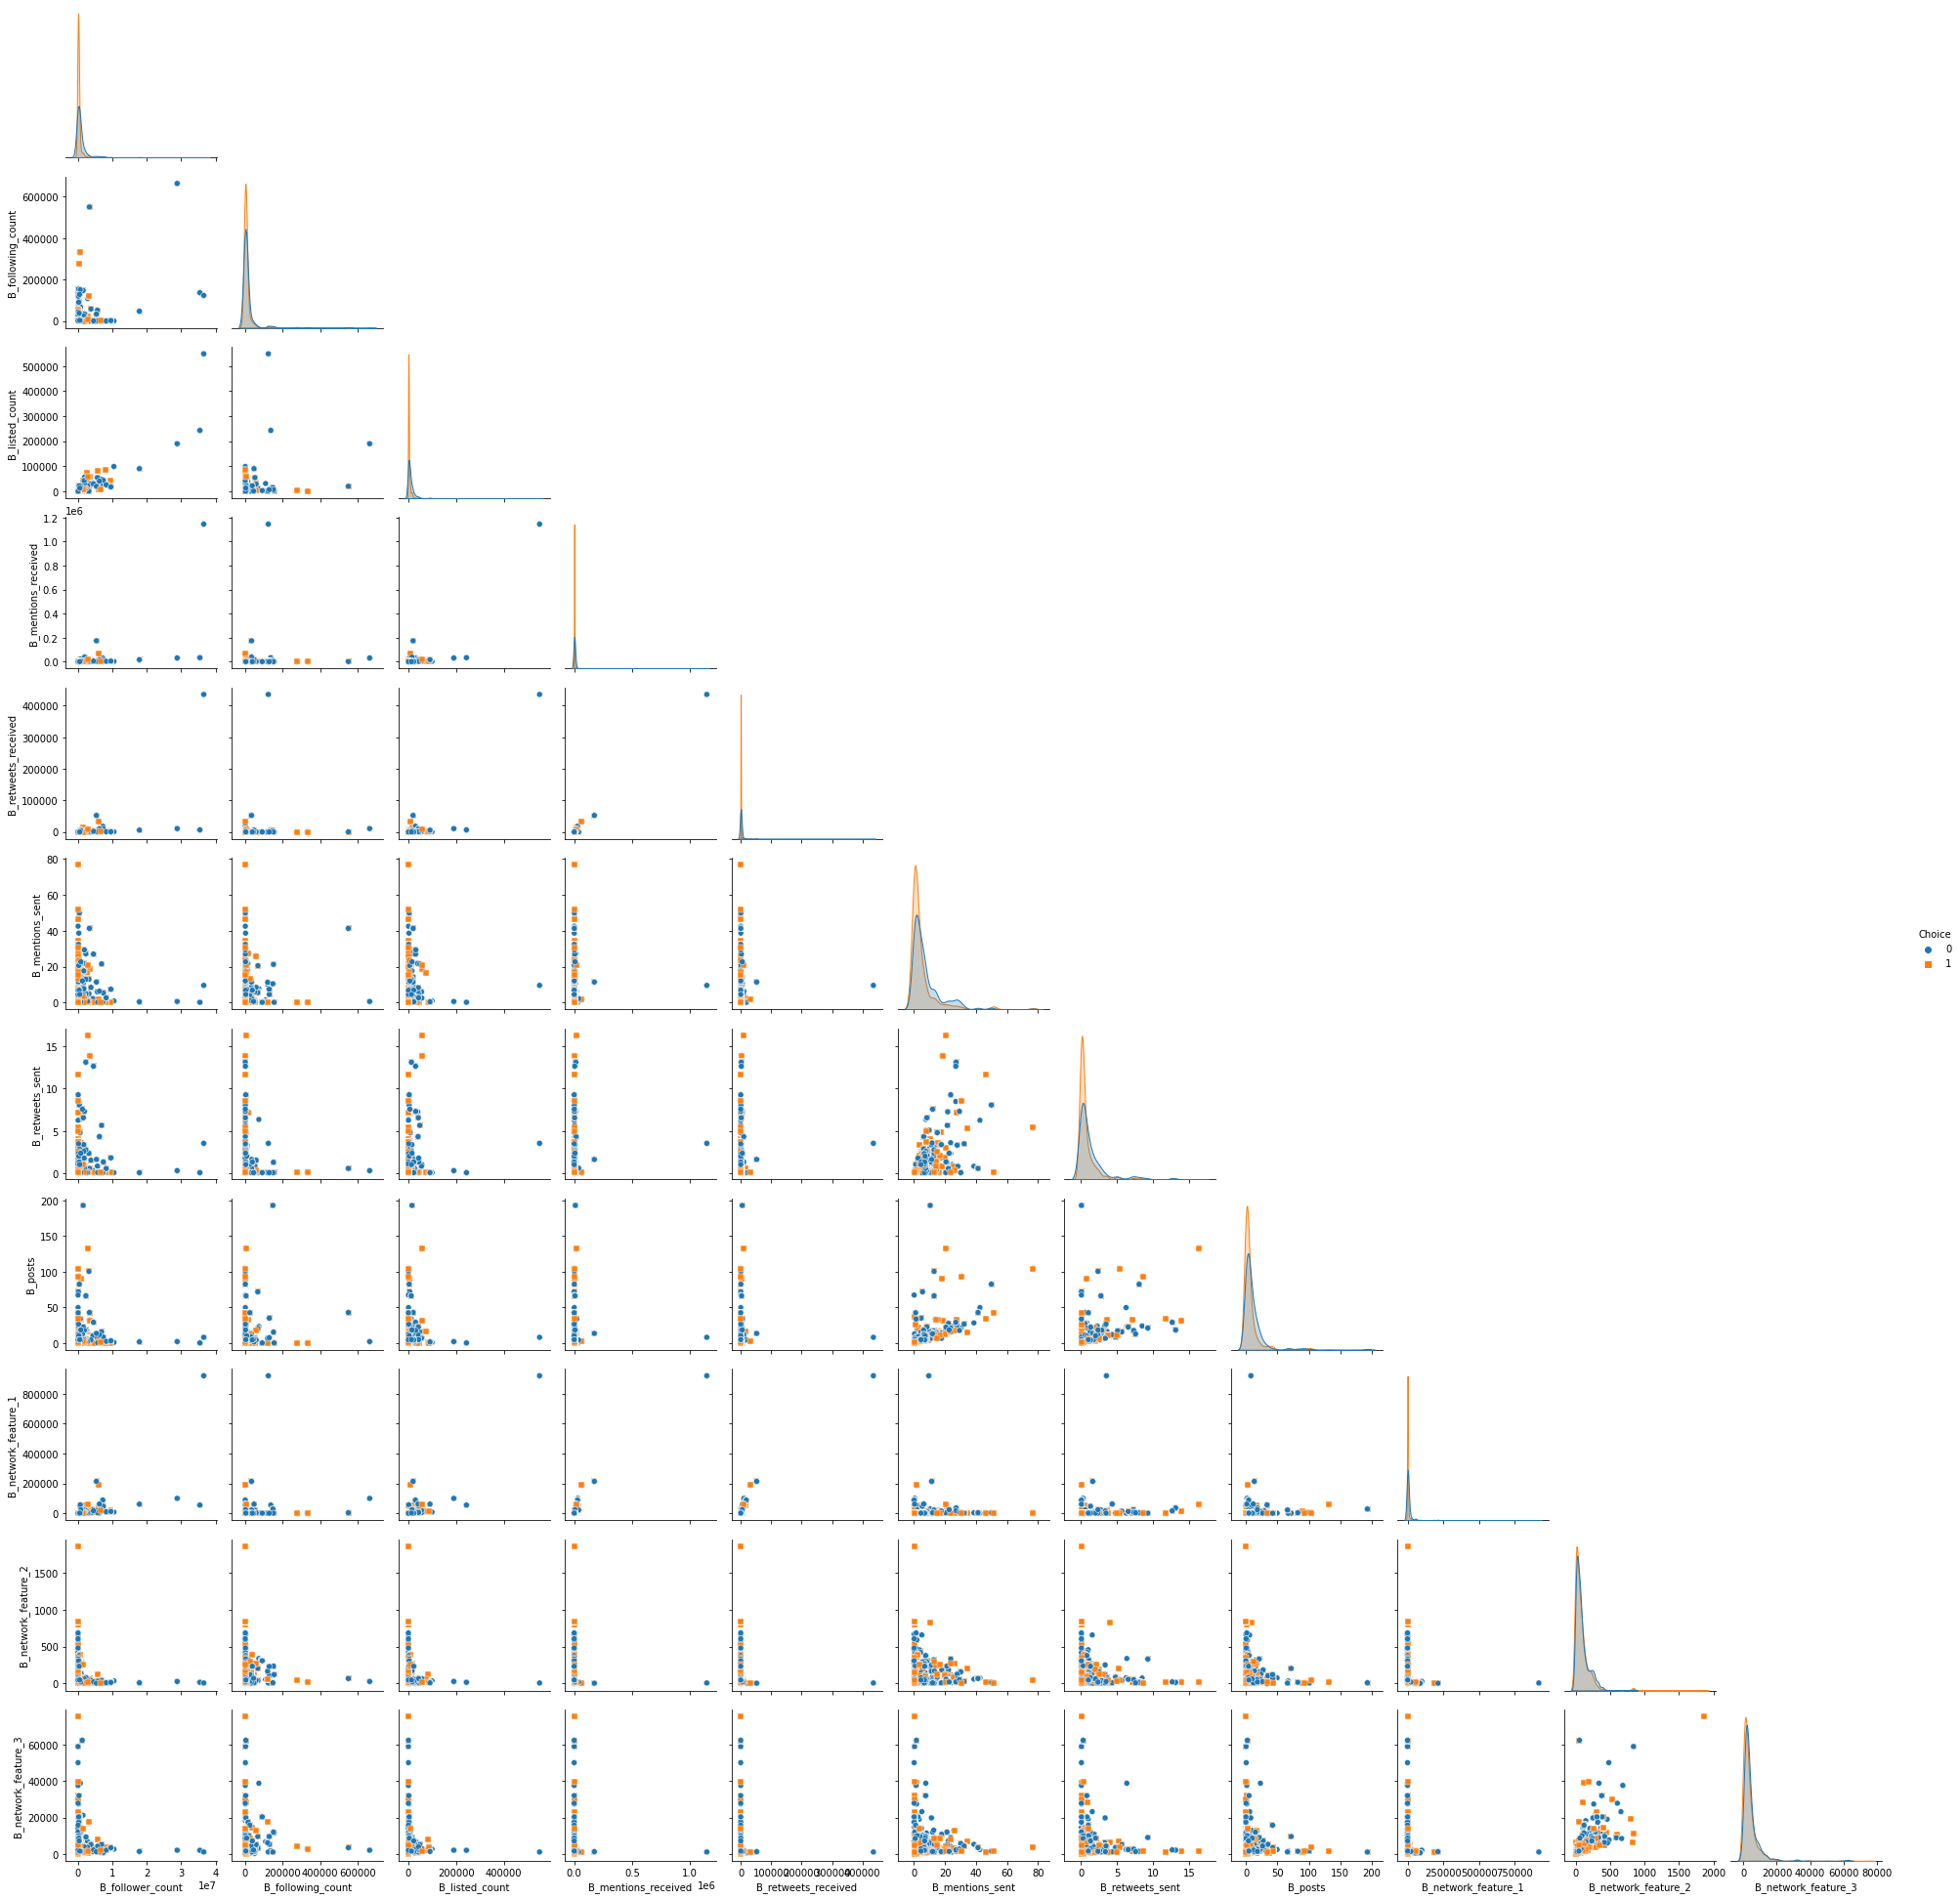

In [63]:
# Scatter plot for person B
train_target = train['Choice']
person_B_train = train.iloc[:, 12:]

df_scatter_plot_B = pd.concat([train_target, person_B_train], axis=1)

sns.pairplot(df_scatter_plot_B, hue="Choice", markers=["o", "s"] , corner=True)

Use Cross Table to indicate whether the given training set is balanced or not. After running the cell it shows that the amount of positive class and negative class are quite balanced.


In [64]:
train_outcome = pd.crosstab(index=train["Choice"],  # Make a crosstab
                              columns="count")      # Name the count column                             
train_outcome

col_0,count
Choice,
0,2632
1,2736


In [ ]:
# Function for displaying the correlation matrix from the given dataframe
def corr_matrix(data_frame):
  plt.matshow(data_frame.corr())
  plt.show()

# Displaying the correlation matrix between each of given attributes
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
Choice,1.000000,0.134133,0.063678,0.135078,0.020745,0.024139,0.123868,0.137833,0.107648,0.065543,0.073995,0.084508,-0.161278,-0.042859,-0.191179,-0.062332,-0.064774,-0.139521,-0.168341,-0.102028,-0.108259,-0.051364,-0.069339
A_follower_count,0.134133,1.000000,0.115834,0.815952,0.511609,0.521888,0.018456,0.094799,0.042993,0.622146,-0.153272,-0.036082,0.155347,0.033327,0.140186,0.029233,0.030709,-0.011715,-0.010649,-0.013452,0.051651,-0.033974,-0.014107
A_following_count,0.063678,0.115834,1.000000,0.100696,0.058140,0.051819,0.111342,-0.083883,0.138373,0.047236,0.043642,0.097762,-0.007616,-0.010944,-0.011792,0.001077,-0.001774,0.006797,0.002244,-0.000280,-0.002475,0.003415,-0.003968
A_listed_count,0.135078,0.815952,0.100696,1.000000,0.734589,0.747752,0.061729,0.155630,0.053975,0.705268,-0.080056,-0.038574,0.211085,0.048962,0.203068,0.045555,0.045333,-0.002835,0.006040,0.003535,0.068414,-0.034576,-0.010478
A_mentions_received,0.020745,0.511609,0.058140,0.734589,1.000000,0.990021,0.023336,0.050100,0.026512,0.922340,-0.062407,-0.038079,0.146134,0.023431,0.136128,0.010900,0.008098,-0.008721,-0.012288,-0.011123,0.023156,-0.017576,-0.011153
A_retweets_received,0.024139,0.521888,0.051819,0.747752,0.990021,1.000000,0.019130,0.043846,0.033068,0.928273,-0.065266,-0.040301,0.149532,0.023340,0.139695,0.011525,0.008719,-0.007203,-0.012692,-0.009671,0.023931,-0.017675,-0.012855
A_mentions_sent,0.123868,0.018456,0.111342,0.061729,0.023336,0.019130,1.000000,0.582630,0.607040,0.032608,0.064242,0.035437,-0.005732,0.027851,0.005401,0.006467,0.010684,0.016772,0.003553,0.019061,0.005172,0.016377,0.014035
A_retweets_sent,0.137833,0.094799,-0.083883,0.155630,0.050100,0.043846,0.582630,1.000000,0.379318,0.081908,-0.048761,-0.042127,0.024915,0.016303,0.038314,0.057745,0.060162,0.029084,0.011914,0.039341,0.050733,-0.004573,0.005986
A_posts,0.107648,0.042993,0.138373,0.053975,0.026512,0.033068,0.607040,0.379318,1.000000,0.074683,-0.066125,-0.018347,-0.011992,0.021679,-0.005321,0.001848,0.005974,0.028039,0.002118,0.023880,-0.001924,0.010813,0.004692
A_network_feature_1,0.065543,0.622146,0.047236,0.705268,0.922340,0.928273,0.032608,0.081908,0.074683,1.000000,-0.118138,-0.071711,0.138820,0.034620,0.127232,0.012452,0.011003,-0.002757,-0.012546,-0.010237,0.026392,-0.023533,-0.015348


# Data Preparation

## Check the data
Before further process on the given dataset, we need to check if each column & rows of the dataset contains the following:

*   **Missing Values** (NaN, NA)
*   **Infinite Values** (-inf, inf)


Note: We have to check on both training set and test set

In case of **Duplicated rows**, we shall remove the duplicated rows in the training set only. This is because the removal of duplicates in test set will result in mismatched number of rows for submission to Kaggle system.


In [69]:
# Check if there are any duplicates -> We dont want it!
# Note: We only drop training set only! Not Test set
train.duplicated().sum()
train = train.drop_duplicates()

# This method will detect both +inf and -inf
def detect_inf(data_frame):
  return data_frame.columns.to_series()[np.isinf(data_frame).any()]

def checkData(data_frame):
  print("data shape: ", data_frame.shape)
  print("Any missing values?:", data_frame.isnull().values.any())
  print("Any inf or -inf?: ", detect_inf(data_frame))

print("------ Training set -------")
checkData(train)
print("------ Test set -------")
checkData(test)

------ Training set -------
data shape:  (5368, 23)
Any missing values?: False
Any inf or -inf?:  Series([], dtype: object)
------ Test set -------
data shape:  (5952, 42)
Any missing values?: False
Any inf or -inf?:  A_follow_ratio    A_follow_ratio
B_follow_ratio    B_follow_ratio
dtype: object


Next, We shall split the original training set into **training set(66 % original training data)**, **validation set(33 % of original training set)** and **test set**, respectively

In [70]:
 # Set of predictors for entire training set
X = train.iloc[:,1:]
# Set of target label corresponding to each sample
Y = train['Choice']
# Set of predictors for entire test set
# Note: Target variable is excluded because we are supposed to predict 'Choice'
X_test = test.iloc[:,:]

# Using helper method from sklearn.model_selection to split training dataset into 2 partitions
# 1) Training set: 66% -> To train the model
# 2) Validation set: 33% -> To evaluate the model
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size= 0.33, random_state=seed)

In our dataset, we pre-process features in the following procedures.


1.   Convert all attributes to float number
2.   Fill in any missing values with 0
3.   Fill in `np.inf`  with maximum value and fill in `-np.inf` with minimum of the respective attribute




In [71]:
def data_pre_process(data_frame):
  # Cast all of the attributes to float
  data_frame = data_frame.astype('float32')
  col = data_frame.columns
  for col in data_frame.columns:
    # Fill in the attribute which has the value as '-inf' with the min of such attribute 
    imputed_min = data_frame.loc[data_frame[col] != -np.inf, col].min()
    data_frame[col].replace(to_replace = -np.inf,value = imputed_min, inplace=True)

    # Fill in the attribute which has the value as 'inf' with the max of such attribute
    imputed_max = data_frame.loc[data_frame[col] != np.inf, col].max()
    data_frame[col].replace(to_replace = np.inf,value = imputed_max, inplace=True)

  # Fill in the missing values with zero  
  data_frame.fillna(0, inplace=True)
  return data_frame


### Scale Features
As we observed from the plot of data distribution in each attribute, we can observe that the distributions are right-skewed due to the outliers within the attribute.

One of the simplest example can be the number of followers where celebrity tends to **have millions of followers**, yet normal people tends to have significantly less followers.

Based on this example, it is not a good practice to remove outliers from the dataset since it will cause the data to be **less realistic or data is lost**.

Therefore, it might be better if we perform experiment with different kinds of scaler on the data that impacts on such outliers.

In this case, we will use 3 different scalers including, **StandardScaler**, **Normalizer**, and **LogTransformer**

**Goal:** Transforming the distribution of the data to be more symmetrical

In [72]:
# Define three scalers including, StandardScaler, Normalizer, LogTransformer
def scale_features(scale_type, data_frame):
  if (scale_type == "StandardScaler"):
    scaler = StandardScaler()
  elif (scale_type == "Normalizer"):
    scaler = Normalizer()
  elif (scale_type =='log'):
    scaler = FunctionTransformer(np.log1p, validate=True)

  scaled_data = scaler.fit_transform(data_frame)
  data_frame = pd.DataFrame(scaled_data, columns = data_frame.columns)
  return data_frame


In [81]:
# Defining a function for plotting data distribution 
def distribution_plots(h, w, x_train, title):
    fig, ax = plt.subplots(h, w, sharex=True,figsize=(12,12))
    plt.suptitle(title)
    axes_list = [item for sublist in ax for item in sublist]
    for col in x_train.columns:
        ax=axes_list.pop(0)
        sns.distplot(x_train[col],ax=ax)
    
    for ax in axes_list:
        ax.remove()

After applying different types of scale_features to x_train, we can observe that the distribution corresponding to each scaler has been changed differently from original training set.

As a result, `LogTransformation` transform the distribution of each attribute in the data into the most symmetric form. This means `LogTransformation` may be the good candidate for scaling the data used for training.

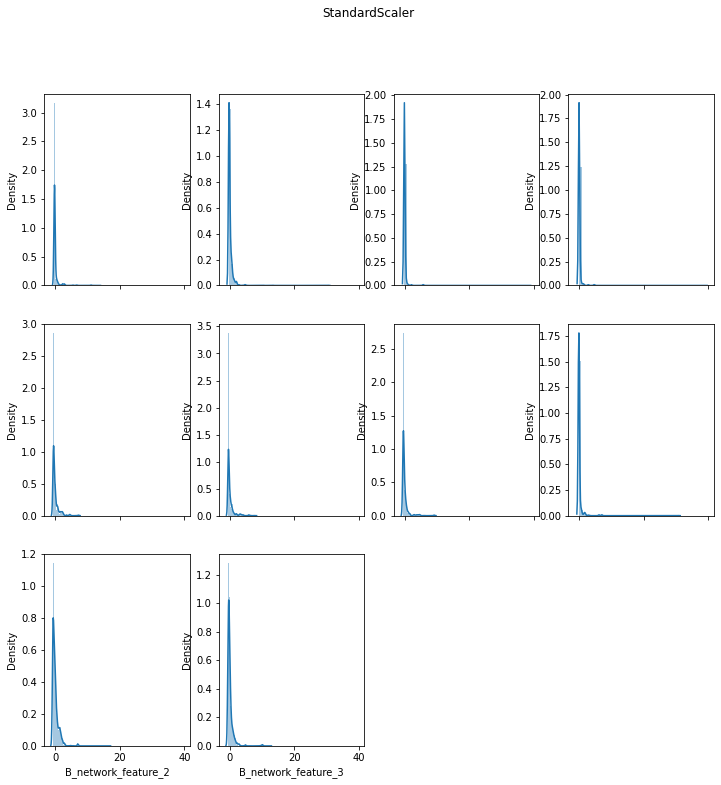

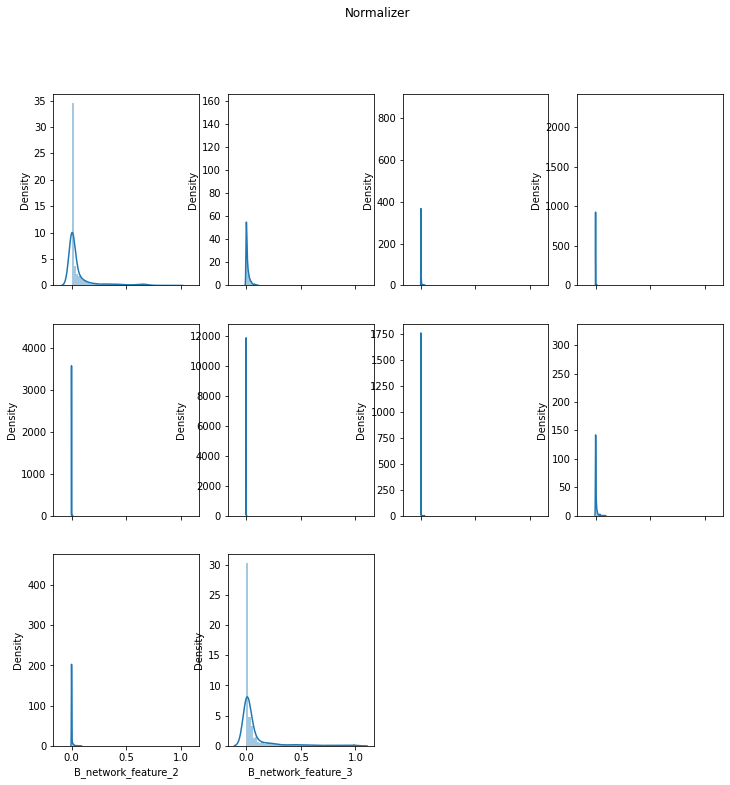

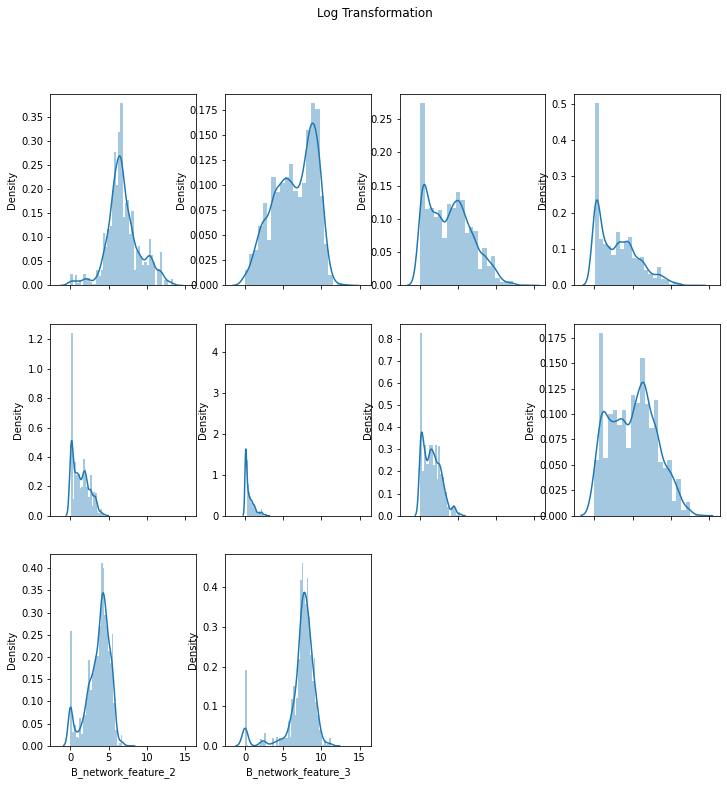

In [82]:
#Applying different scaling and log transformation 
x_train_standard = scale_features('StandardScaler',x_train)
x_train_normalizer = scale_features('Normalizer',x_train)
x_train_log = scale_features('log',x_train)

# Visualise the distributions after applying different scaling type.
distribution_plots(3,4, x_train_standard.iloc[:,12:], "StandardScaler")
distribution_plots(3,4, x_train_normalizer.iloc[:,12:],  "Normalizer" )
distribution_plots(3,4, x_train_log.iloc[:,12:], "Log Transformation")

### Dimensionality Reduction: Principle Component Analysis

We introduce PCA to use in the case that if the number of dimension grows very large. We shall compare if we use PCA shall have the impact on the performance in general or not.

In [ ]:
num_principle_components = 15
def applyPCA(data_frame, n):
  # Extract Features with Principle Component Analysis
  print("data_frame before PCA: ", data_frame.shape)

  train_pca = decomposition.PCA(n_components = n,whiten=True)

  std_pca = train_pca.fit_transform(data_frame)
  print("data_frame after PCA: ", std_pca.shape)

  return std_pca

### Setup training baseline

We make use of this baseline to experiment on each type of scale transformation to figure out which scale transformation will help to improve the accuracy of the prediction after training the most.

In [ ]:
nFolds = 20

# Method used to call set of candidate models [RandomForestClassifier, XGBClassifier, MLPClassifier]
def get_model():
    models = []
    models.append(('RandomForestClassifier' , RandomForestClassifier(n_estimators=100)))
    models.append(('XGBClassifier', XGBClassifier()))
    models.append(('MLPClassifier', MLPClassifier()))
    return models

# Setup the workflow for training baseline models on given training dataset
def base_line_performance(x_train, y_train, models):
    scoring = 'accuracy'
    results = []
    names = []
    for name, model in models:
        # Make use of Stratified cross validation to make sure that each fold in cross-validation
        # has the same portion of training set and test set.
        skf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=seed)
        lst_accu_stratified = []

        # Train the model on each fold of stratefied cross validation
        for train_index, test_index in skf.split(x_train, y_train):
            x_train_fold, x_test_fold = x_train.iloc[train_index,:], x_train.iloc[test_index,:]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
            model.fit(x_train_fold, y_train_fold)
            lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))

        # Summarise the training with stratified cross-validation
        mean = np.mean(lst_accu_stratified)
        std = np.std(lst_accu_stratified)
        names.append(name)
        results.append({"mean": mean, "std":std})
        print('{}: {:.4} ({:.4})'.format(name, mean, std))
    return names, results

# We also try to apply PCA for training our baseline models to check 
# if it improves the genaralization performance
def performance_with_pca(x_train, y_train, models, n_components):
  # Same process with base_line_performance but we transform the data with PCA before start training
  x_train = applyPCA(x_train, n_components)
  scoring = 'accuracy'
  results = []
  names = []
  for name, model in models:
      skf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=seed)
      lst_accu_stratified = []

      for train_index, test_index in skf.split(x_train, y_train):
          x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
          y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
          model.fit(x_train_fold, y_train_fold)
          lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
        
      mean = np.mean(lst_accu_stratified)
      std = np.std(lst_accu_stratified)
      names.append(name)
      results.append({"mean": mean, "std":std})
      print('{}: {:.4} ({:.4})'.format(name, mean, std))
  return names, results

Now, we notice that based on baseline performance for each type of scaled_features, we can see that x_train_log has slightly outperformed among other scaled_features.

Although, we tried to apply PCA to the scaled_features in order to reduce the dimensionality of the data, the generalisation performance still do not improve. This is because the dimensionality of the given dataset is not large, and thus PCA does not have huge impact in improving the performance of the model.

In [ ]:
models = get_model()

print("-------------------- StandardScaler --------------------\n")
names_standard,results_standard = base_line_performance(x_train_standard, y_train,models)

print("\n-------------------- Normalizer --------------------\n")
names_normalizer,results_normalizer = base_line_performance(x_train_normalizer, y_train,models)

print("\n-------------------- Log Transformation --------------------\n")
names_log,results_log = base_line_performance(x_train_log, y_train,models)

print("\n-------------------- Log Transformation with PCA --------------------\n")
names_log_pca, results_log_pca = performance_with_pca(x_train_log, y_train, models, num_principle_components)

-------------------- StandardScaler --------------------
RandomForestClassifier: 0.7592 (0.02853)
XGBClassifier: 0.7756 (0.02835)
MLPClassifier: 0.7575 (0.0255)
-------------------- Normalizer --------------------
RandomForestClassifier: 0.7636 (0.02395)
XGBClassifier: 0.7734 (0.02717)
MLPClassifier: 0.7558 (0.03291)
-------------------- Log Transformation --------------------
RandomForestClassifier: 0.7578 (0.02175)
XGBClassifier: 0.7756 (0.02835)
MLPClassifier: 0.7678 (0.03361)
-------------------- Log Transformation with PCA --------------------
data_frame before PCA:  (3596, 22)
data_frame after PCA:  (3596, 15)
RandomForestClassifier: 0.7633 (0.03075)
XGBClassifier: 0.7759 (0.03094)
MLPClassifier: 0.767 (0.03441)


### Additional Assumption
As we are constructing the model for pair-wise preference learning task, we may need to observe the difference in each attribute for each user A and user B.

Possible relationship between user A and user B may include the following:


1.   **Difference between attributes in User A and User B?**
2.   **Ratio w.r.t some attribute for each user A or B**



In [119]:
print("---------------- Check Data before feature selection ----------------\n")
print(checkData(train))

# Normalize the column which will be used in feature extraction
def normalize_col(col):
  normalized_df = (col-col.min())/(col.max()-col.min())
  return normalized_df

def feature_extract(data_frame):
  # To avoid any zero-division in 
  data_frame.replace(0, 0.0001)

  # Compute the normalized difference between User A and User B

  # Normalize the difference to ensure that the difference has common scale, without distorting differences in the ranges of values.
  data_frame['follower_diff'] = normalize_col(data_frame['A_follower_count'] - data_frame['B_follower_count'])
  data_frame['following_diff'] = normalize_col(data_frame['A_following_count'] - data_frame['B_following_count'])
  data_frame['listed_diff'] = normalize_col(data_frame['A_listed_count'] - data_frame['B_listed_count'])
  data_frame['mention_rec_diff'] = normalize_col(data_frame['A_mentions_received'] - data_frame['B_mentions_received'])
  data_frame['retweets_rec_diff'] = normalize_col(data_frame['A_retweets_received'] - data_frame['B_retweets_received'])
  data_frame['mention_sent_diff'] = normalize_col(data_frame['A_mentions_sent'] - data_frame['B_mentions_sent'])
  data_frame['retweet_sent_diff'] = normalize_col(data_frame['A_retweets_sent'] - data_frame['B_retweets_sent'])
  data_frame['posts_diff'] = normalize_col(data_frame['A_posts'] - data_frame['B_posts'])
  data_frame['nf1_diff'] = normalize_col(data_frame['A_network_feature_1'] - data_frame['B_network_feature_1'])
  data_frame['nf2_diff'] = normalize_col(data_frame['A_network_feature_2'] - data_frame['B_network_feature_2'])
  data_frame['nf3_diff'] = normalize_col(data_frame['A_network_feature_3'] - data_frame['B_network_feature_3'])

  # Ratio w.r.t some attributes for each user A and B
  # Follow Ratio  -> indicates if a user has more followers than following
  # Mention Ratio -> indicate if a user has been mentioned more than mention others
  # Retweet Ratio -> indicate if a user receive retweets more than retweeting
  data_frame['A_follow_ratio'] = data_frame['A_follower_count']/data_frame['A_following_count']
  data_frame['A_mention_ratio'] = data_frame['A_mentions_received']/data_frame['A_mentions_sent']
  data_frame['A_retweets_ratio'] = data_frame['A_retweets_received']/data_frame['A_retweets_sent']
      
  data_frame['B_follow_ratio'] = data_frame['B_follower_count']/data_frame['B_following_count']
  data_frame['B_mention_ratio'] = data_frame['B_mentions_sent']/data_frame['B_mentions_received']
  data_frame['B_retweets_ratio'] = data_frame['B_retweets_sent']/data_frame['B_retweets_received']
  
  # Check if user A has higher follow ratio than user B
  data_frame['follow_ratio_diff'] = normalize_col(data_frame['A_follow_ratio'] - data_frame['B_follow_ratio'])
  # Check if user A has higher mention ratio than user B
  data_frame['mention_ratio_diff'] = normalize_col(data_frame['A_mention_ratio'] - data_frame['B_mention_ratio'])
  # Check if user A has higher retweets ratio than user B
  data_frame['retweets_ratio_diff'] = normalize_col(data_frame['A_retweets_ratio'] - data_frame['B_retweets_ratio'])

  # Casting each column with boolean type to float(0.00000 = False, 1.0000 = True)
  for col in data_frame.columns:
    if(data_frame[col].dtype == 'bool'):
      data_frame[col] = data_frame[col].astype(int)
      data_frame[col] = data_frame[col].astype('float32')

  # Pre-process the data
  feature_extracted_data = data_pre_process(data_frame)

  # feature_extracted_data = applyPCA(feature_extracted_data, num_principle_components)

  return feature_extracted_data

# Adding additional features to training set, validation set and test set
Y = train['Choice']
X = train.drop('Choice', axis = 1)
X_log_scaled = scale_features('log', feature_extract(X))
X = X_log_scaled

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size= 0.33, random_state=seed)

x_test_log_scaled = scale_features('log',feature_extract(X_test))
x_test = x_test_log_scaled

print("\n---------------- Check Data after feature selection ----------------\n")
print(checkData(X))


---------------- Check Data before feature selection ----------------
data shape:  (5368, 23)
Any missing values?: False
Any inf or -inf?:  Series([], dtype: object)
None
---------------- Check Data after feature selection ----------------
data shape:  (5368, 42)
Any missing values?: False
Any inf or -inf?:  Series([], dtype: object)
None


Now we would like to try to **eliminate some redundant features** existing in the training set. In this case, we used only **Variable Importance** in order to see how each variable impacts to the prediction of XGBoostClassifier model.

For variable importance, we **expect the difference to be positive**, but in the cases of a negative number, it denotes that the random permutation worked better. It can be inferred that the variable does not have a role in the prediction ,i.e, not important.

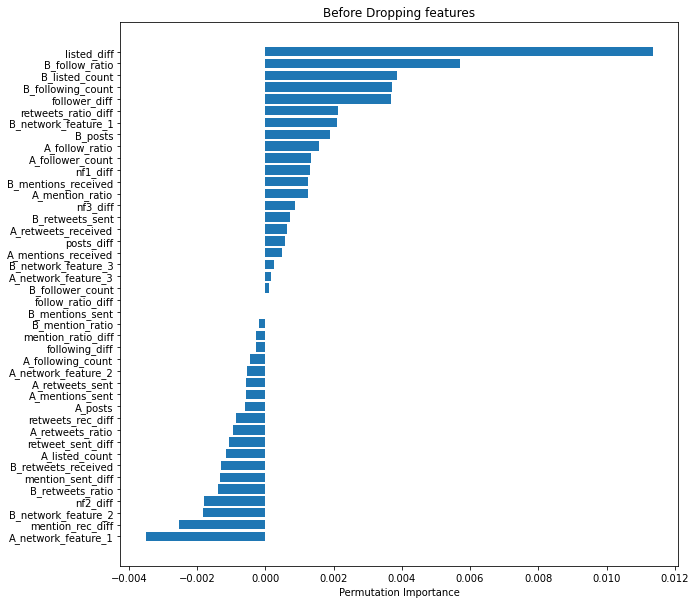

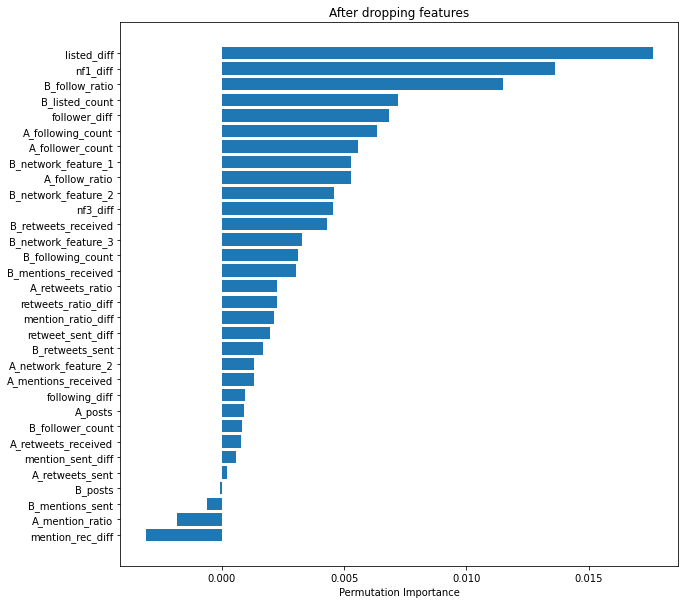

In [137]:
from sklearn.inspection import permutation_importance

# Function used to plot variable importance with XGBoostClassifier
def feature_importance(x_train, y_train, x_val, y_val, title):
  model = XGBClassifier()
  model.fit(x_train, y_train)

  perm_importance = permutation_importance(model, x_val, y_val, n_repeats=30, random_state=seed)
  sorted_idx = perm_importance.importances_mean.argsort()

  fig2, ax2 = plt.subplots(figsize=(10,10))
  plt.barh(x_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
  plt.xlabel("Permutation Importance")
  plt.title(title)

# Plot the feature importance graph for sets of data before eliminating redundant features
feature_importance(x_train, y_train, x_val, y_val, "Before Dropping features")


# Drop some features which its importance value based on permutation importance are negative
dropped_features = ['A_mentions_sent', 'nf2_diff', 'A_listed_count', 'A_network_feature_1',
                    'retweets_rec_diff', 'A_network_feature_3', 'posts_diff', 'B_mention_ratio'
                    , 'B_retweets_ratio', 'follow_ratio_diff']

# Set of datasets that we eliminate redundant features
x_train_dropped = x_train.drop(dropped_features, axis=1)
x_val_dropped =  x_val.drop(dropped_features, axis=1)
x_test_dropped = x_test.drop(dropped_features, axis=1)

# Plot the feature importance graph for sets of data after eliminating redundant features
feature_importance(x_train_dropped, y_train, x_val_dropped, y_val, "After dropping features")

In [115]:
# View the correlation between attributes after eliminating some redundant features
corr = x_train_dropped.corr()
corr.style.background_gradient(cmap='coolwarm')

,A_follower_count,A_following_count,A_mentions_received,A_retweets_received,A_retweets_sent,A_posts,A_network_feature_2,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3,follower_diff,following_diff,listed_diff,mention_rec_diff,mention_sent_diff,retweet_sent_diff,nf1_diff,nf3_diff,A_follow_ratio,A_mention_ratio,A_retweets_ratio,B_follow_ratio,mention_ratio_diff,retweets_ratio_diff
A_follower_count,1.000000,0.285438,0.865601,0.840200,0.321848,0.445279,0.193664,0.091670,0.040418,0.081550,0.081404,0.082586,0.040484,0.010418,0.045717,0.078315,-0.014511,0.021631,0.288205,0.086983,0.255496,0.072799,0.135709,0.174983,0.155537,0.123779,0.706170,0.763117,0.796238,0.056795,0.210899,0.244832
A_following_count,0.285438,1.000000,0.169665,0.116468,0.002692,0.137272,0.312365,0.001779,0.007046,0.005136,0.003941,0.010284,-0.006163,-0.011115,0.004702,0.000388,-0.033062,-0.025512,0.042256,0.361568,0.071944,0.056695,0.065185,0.001073,0.035379,0.199563,-0.443008,0.089478,0.148683,-0.001132,-0.069991,-0.047574
A_mentions_received,0.865601,0.169665,1.000000,0.967990,0.433197,0.617327,0.128738,0.094811,0.046247,0.083411,0.081939,0.084166,0.045594,0.020492,0.048075,0.078798,-0.013329,0.015161,0.286617,0.023297,0.268321,0.121556,0.215196,0.234847,0.232588,0.025284,0.665703,0.815327,0.870469,0.055391,0.276392,0.348606
A_retweets_received,0.840200,0.116468,0.967990,1.000000,0.430155,0.616937,0.041854,0.093245,0.044033,0.081524,0.080205,0.081341,0.046337,0.019611,0.048108,0.076899,-0.011044,0.015801,0.293646,0.013334,0.271816,0.125438,0.202711,0.241925,0.247835,0.002964,0.683463,0.799914,0.898387,0.056250,0.293658,0.383412
A_retweets_sent,0.321848,0.002692,0.433197,0.430155,1.000000,0.609801,0.128784,0.034824,-0.002053,0.018539,0.014507,0.020227,0.015830,0.015204,0.032984,0.012674,-0.012527,0.005032,0.052157,-0.075588,0.103910,0.005341,0.351472,0.588378,0.020264,-0.032654,0.276663,0.047983,0.025193,0.031450,-0.073444,-0.089550
A_posts,0.445279,0.137272,0.617327,0.616937,0.609801,1.000000,0.190869,0.058707,0.050969,0.047387,0.037251,0.039001,0.050618,0.028455,0.053625,0.038023,0.022030,0.032919,0.035439,-0.008687,0.078063,0.019023,0.414486,0.330776,0.059607,0.010311,0.295273,0.169270,0.410962,0.018690,0.000201,0.050939
A_network_feature_2,0.193664,0.312365,0.128738,0.041854,0.128784,0.190869,1.000000,-0.019971,-0.004686,-0.020098,-0.022597,-0.018258,-0.006537,-0.028131,-0.008604,-0.020236,0.011968,0.002501,-0.086901,0.079858,-0.005633,-0.045113,0.122924,0.055779,-0.089971,0.289545,-0.068564,-0.035413,0.032129,-0.018599,-0.126572,-0.159219
B_follower_count,0.091670,0.001779,0.094811,0.093245,0.034824,0.058707,-0.019971,1.000000,0.307480,0.933410,0.862409,0.839983,0.397999,0.340753,0.462360,0.878249,0.146025,0.404001,-0.325256,-0.169676,-0.250587,-0.081296,-0.164139,-0.194426,-0.168940,-0.122153,0.077911,0.075992,0.087983,0.699648,0.018072,0.012068
B_following_count,0.040418,0.007046,0.046247,0.044033,-0.002053,0.050969,-0.004686,0.307480,1.000000,0.309148,0.207169,0.159339,0.193678,0.024340,0.178759,0.207482,0.264885,0.271697,-0.072408,-0.393143,-0.083426,-0.058005,-0.028383,-0.003566,-0.044251,-0.152214,0.031940,0.024118,0.049237,-0.434397,0.002026,0.031799
B_listed_count,0.081550,0.005136,0.083411,0.081524,0.018539,0.047387,-0.020098,0.933410,0.309148,1.000000,0.844407,0.812560,0.438787,0.341501,0.467706,0.865437,0.249487,0.403942,-0.270327,-0.145882,-0.266147,-0.074201,-0.188914,-0.200818,-0.144318,-0.069254,0.065978,0.071801,0.081570,0.631540,0.017163,0.008907


In [147]:
# Train the baseline model on the training set before eliminating reduntant features
print("--------------------- Train before eliminating reduntant features ---------------------\n")
names_log,results_log = base_line_performance(x_train, y_train, models)

# Train the baseline model on the training set after eliminating reduntant features
print("\n--------------------- Train after eliminating reduntant features---------------------\n")
names_log,results_log = base_line_performance(x_train_dropped, y_train, models)

--------------------- Train before eliminating reduntant features ---------------------

RandomForestClassifier: 0.7636 (0.0245)
XGBClassifier: 0.7742 (0.02829)
MLPClassifier: 0.7589 (0.03335)

--------------------- Train after eliminating reduntant features---------------------

RandomForestClassifier: 0.7611 (0.02546)
XGBClassifier: 0.7728 (0.02826)
MLPClassifier: 0.767 (0.03521)


After training the model with the data before and after eliminating redundant features, we observe that the accuracy of the prediction for each baseline models does not vary much.

Therefore, we decided to use the set of features after eliminating redundant features for training models in the next step.

# Modelling

Now we will start to model the machine learning model which we can use in order to predict the human judgement on who is more influential based on the pre-processed data from the previous secion.

In this test, we would like to experiment on three models including, **NeuralNetwork, RandomForestClassifier, and XGBoostClassifier**, respectively

### Neural Network
Since the baseline performance also indicates that **MLP model also work quite well similarly to other baseline models**, we may consider using Neural Network as the model of choice to predict the human judgement on who is more influential with high accuracy.

It appears that MLP in sklearn have certain limitations in the flexibility in modeling the neural network, so we decide to model 1D Neural Network with the help of `keras framework` in modelling the deep neural network model. This allows us to modify the neural network in deeper details. For instance, adjusting the activation function in each layer, etc.

In [121]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

def createNNModel(learning_rate):
  nn_model = Sequential()

  nn_model.add(Dense(30, activation=tf.nn.leaky_relu,kernel_initializer='uniform', input_dim=x_train_dropped.shape[1]))
  nn_model.add(Dropout(0.20))
  nn_model.add(Dense(20, activation=tf.nn.leaky_relu, kernel_initializer='uniform'))
  nn_model.add(Dropout(0.20))
  nn_model.add(Dense(10, activation=tf.nn.relu, kernel_initializer='uniform'))
  nn_model.add(BatchNormalization())
  nn_model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))

  adam = Adam(learning_rate= learning_rate)    
  nn_model.compile(loss='binary_crossentropy', optimizer= adam, metrics=['accuracy'])

  return nn_model

nn_model = KerasClassifier(build_fn=createNNModel, verbose=1)
# Uncomment this block in case we would like to train the model without performing grid search

# model = createNNModel(10**-3)
# model.fit(x_train_dropped, y_train, epochs=200, batch_size=64, validation_data=(x_val_dropped, y_val))
# _, accuracy = model.evaluate(x_val_dropped, y_val)
# print("Accuracy", accuracy)

# predictions = model.predict(x_test_dropped).flatten()
# print(predictions)

## Hyper-parameter Tuning
So far, we have worked throgh data understanding as well as data pre-processing. We have seen some candidates model perform relatively well even though the baseline models are used without any searching process for optimal hyperparameters.

To optimize the model to perform better, we need to perform hyper-parameter tuning in order to pick a set of hyper-parameters for our candidate learning algorithms.

In this scenario, we introduce **grid search** where we set up a grid of hyperparameter values and for each combination, trains a model and scores on the testing data. In this approach, every combination of hyperparameter values is substituted into the model.

#### Steps


1.   Set up the grid of hyperparameter values for each combination
2.   Pass the set of hyperparameters and the corresponding model into the constructor of `GridSearchCV`
3.   Obtain the best performance model among the search process together with the set of best hyperparameters which will be use to predict the final result.



**Note:** The higher number of hyperparameters in the model, the larger search space of the grid search will be. Therefore, we would rather keep the number of hyperparameters for grid serch low!

In [122]:
# Set of hyperparameters for each model
neural_net_params = {
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'batch_size' : [10, 24, 64], 
    'epochs' : [1, 2, 5]
}

random_forest_params = {
    'n_estimators':[50,100,300],
    'max_depth': [4,6,8,12],
    # Number of features to consider at every split
    'max_features' : ['auto', 'sqrt'],
    # Method of selecting samples for training each tree
    'bootstrap': [True, False]
}

xg_boost_params = {
    'n_estimators':[100, 200, 300, 400, 500],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}


In [123]:
def summarize_grid_search(grid_results):
  # Summarize the results in a readable format
  print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

  means = grid_results.cv_results_['mean_test_score']
  stds = grid_results.cv_results_['std_test_score']
  params = grid_results.cv_results_['params']

  for mean, stdev, param in zip(means, stds, params):
      print('{0} ({1}) with: {2}'.format(mean, stdev, param))

In [ ]:
# Perform Grid Search for Neural Network
grid = GridSearchCV(estimator=nn_model, param_grid= neural_net_params,
                    cv=KFold(random_state=seed), verbose=10)

# Perform the search and return the best accuracy with corresponding best set of hyperparameters
grid_results = grid.fit(x_train_dropped, y_train)

# Show the summary of the best performed Neural Network Classifier model
summarize_grid_search(grid_results)

# Perform prediction on test set
predictions = grid_results.predict(x_test_dropped).flatten()
print(predictions)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] batch_size=10, epochs=1, learning_rate=0.1 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


72/72 [==============================] - 1s 1ms/step - loss: 0.6353 - accuracy: 0.7569
[CV]  batch_size=10, epochs=1, learning_rate=0.1, score=0.757, total=  17.9s
[CV] batch_size=10, epochs=1, learning_rate=0.1 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.5127 - accuracy: 0.7455
[CV]  batch_size=10, epochs=1, learning_rate=0.1, score=0.745, total=   2.3s
[CV] batch_size=10, epochs=1, learning_rate=0.1 ......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.2s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.5418 - accuracy: 0.7524
[CV]  batch_size=10, epochs=1, learning_rate=0.1, score=0.752, total=   2.2s
[CV] batch_size=10, epochs=1, learning_rate=0.1 ......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.5s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.6699 - accuracy: 0.7858
[CV]  batch_size=10, epochs=1, learning_rate=0.1, score=0.786, total=   2.5s
[CV] batch_size=10, epochs=1, learning_rate=0.1 ......................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.0s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.7622
[CV]  batch_size=10, epochs=1, learning_rate=0.1, score=0.762, total=   2.6s
[CV] batch_size=10, epochs=1, learning_rate=0.01 .....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.5s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.4861 - accuracy: 0.7611
[CV]  batch_size=10, epochs=1, learning_rate=0.01, score=0.761, total=   2.4s
[CV] batch_size=10, epochs=1, learning_rate=0.01 .....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   30.0s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.5054 - accuracy: 0.7580
[CV]  batch_size=10, epochs=1, learning_rate=0.01, score=0.758, total=   2.4s
[CV] batch_size=10, epochs=1, learning_rate=0.01 .....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.3s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.5138 - accuracy: 0.7413
[CV]  batch_size=10, epochs=1, learning_rate=0.01, score=0.741, total=   2.5s
[CV] batch_size=10, epochs=1, learning_rate=0.01 .....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   34.8s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.4740 - accuracy: 0.7789
[CV]  batch_size=10, epochs=1, learning_rate=0.01, score=0.779, total=   2.4s
[CV] batch_size=10, epochs=1, learning_rate=0.01 .....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.2s remaining:    0.0s


72/72 [==============================] - 0s 1ms/step - loss: 0.4871 - accuracy: 0.7538
[CV]  batch_size=10, epochs=1, learning_rate=0.01, score=0.754, total=   3.1s
[CV] batch_size=10, epochs=1, learning_rate=0.001 ....................
72/72 [==============================] - 0s 1ms/step - loss: 0.5583 - accuracy: 0.7278
[CV]  batch_size=10, epochs=1, learning_rate=0.001, score=0.728, total=   2.4s
[CV] batch_size=10, epochs=1, learning_rate=0.001 ....................
72/72 [==============================] - 0s 1ms/step - loss: 0.5526 - accuracy: 0.7288
[CV]  batch_size=10, epochs=1, learning_rate=0.001, score=0.729, total=   2.3s
[CV] batch_size=10, epochs=1, learning_rate=0.001 ....................
72/72 [==============================] - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7357
[CV]  batch_size=10, epochs=1, learning_rate=0.001, score=0.736, total=   2.3s
[CV] batch_size=10, epochs=1, learning_rate=0.001 ....................
72/72 [==============================] - 0s 1ms/step 

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  8.9min finished


57/57 [==============================] - 1s 2ms/step - loss: 0.5730 - accuracy: 0.7295
Epoch 2/5
57/57 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7779
Epoch 3/5
57/57 [==============================] - 0s 2ms/step - loss: 0.4698 - accuracy: 0.7611
Epoch 4/5
57/57 [==============================] - 0s 2ms/step - loss: 0.4974 - accuracy: 0.7469
Epoch 5/5
57/57 [==============================] - 0s 2ms/step - loss: 0.4868 - accuracy: 0.7524
Best: 0.7686296463012695, using {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.01}
0.7605682969093323 (0.013761200975314726) with: {'batch_size': 10, 'epochs': 1, 'learning_rate': 0.1}
0.7586200118064881 (0.01215692699905132) with: {'batch_size': 10, 'epochs': 1, 'learning_rate': 0.01}
0.7388796210289001 (0.0188905371236358) with: {'batch_size': 10, 'epochs': 1, 'learning_rate': 0.001}
0.7436007022857666 (0.012584493767356113) with: {'batch_size': 10, 'epochs': 1, 'learning_rate': 0.0001}
0.7530513048171997 (0.02509

In [124]:
# Perform Grid Search for XGBoost Classifier
xgb = XGBClassifier()
xgb_grid = GridSearchCV(estimator = xgb,
                        param_grid = xg_boost_params,
                        scoring="accuracy", n_jobs=-1, cv=KFold(random_state=seed, shuffle = True))

# Perform the search and return the best accuracy with corresponding best set of hyperparameters
xgb_grid_results = xgb_grid.fit(x_train_dropped, y_train)

# Show the summary of the best performed XGBoost Classifier model
summarize_grid_search(xgb_grid_results)

# Perform prediction on test set
predictions = xgb_grid_results.predict(x_test_dropped)
print(predictions)

Best: 0.7750320661412454, using {'learning_rate': 0.1, 'n_estimators': 100}
0.7455528511821975 (0.015068501247444108) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.7441620305980529 (0.015580047982008356) with: {'learning_rate': 0.0001, 'n_estimators': 200}
0.7441620305980529 (0.015580047982008356) with: {'learning_rate': 0.0001, 'n_estimators': 300}
0.7452746870653686 (0.015131336969529717) with: {'learning_rate': 0.0001, 'n_estimators': 400}
0.7466655076495132 (0.01502195850582052) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.7502808684901869 (0.016844555046406924) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.7561219286045433 (0.02107243941069262) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.7597365167671148 (0.018474369930914766) with: {'learning_rate': 0.001, 'n_estimators': 300}
0.7608499459125329 (0.018679698173388545) with: {'learning_rate': 0.001, 'n_estimators': 400}
0.7611277236903107 (0.015351513797954564) with: {'learning_rate': 0.001, 'n

In [125]:
# Perform Grid Search for Random Forest Classifier
random_forest = RandomForestClassifier()
rf_grid = GridSearchCV(estimator= random_forest , param_grid = random_forest_params,
                       scoring='accuracy',n_jobs=4,iid=False,
                       cv=KFold(random_state=seed ,shuffle = True))

# Perform the search and return the best accuracy with corresponding best set of hyperparameters
rf_grid_results = rf_grid.fit(x_train_dropped, y_train)

# Show the summary of the best performed XGBoost Classifier model
summarize_grid_search(rf_grid_results)

# Perform the prediction on the test_set
predictions = rf_grid_results.predict(x_test_dropped)
print(predictions)

Best: 0.7750301344459898, using {'bootstrap': False, 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}
0.7689136145881625 (0.014102354115103249) with: {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 50}
0.7683569000154535 (0.011688917041957007) with: {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
0.7675251120383247 (0.016775036353178462) with: {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 300}
0.7700278164116828 (0.012282607384790204) with: {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}
0.767247334260547 (0.017651060480062604) with: {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
0.7683584453716581 (0.015822182932033507) with: {'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 300}
0.7741960284345542 (0.012254159272512803) with: {'bootstrap': True, 'max_depth': 6, 'max_features': 'auto', 'n_esti

------------------ Best accuracy of candidate models ------------------

Neural Net:  0.7686296463012695
Random Forest:  0.7750301344459898
XGBoost Classifier:  0.7750320661412454
Accuracy on train:  0.8337041156840934
Accuracy on test: 0.7753950338600452

------------------ Classification report ------------------

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       873
           1       0.78      0.78      0.78       899

    accuracy                           0.78      1772
   macro avg       0.78      0.78      0.78      1772
weighted avg       0.78      0.78      0.78      1772


------------------ Confusion Matrix -------------------



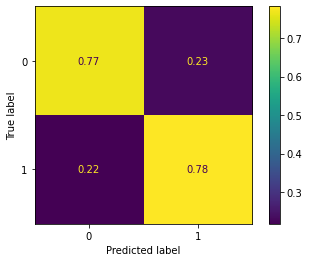


------------------ Final predictions ------------------

[0.2771608 0.344509  0.0389571 ... 0.3096204 0.2542067 0.2522833]


In [146]:
from sklearn.metrics import classification_report, plot_confusion_matrix

# Compare the accuracy of Neural Network, Random Forest, and XGBoostClassifier after grid search
print("------------------ Best accuracy of candidate models ------------------\n")
print("Neural Net: ", grid_results.best_score_)
print("Random Forest: ", rf_grid_results.best_score_)
print("XGBoost Classifier: ", xgb_grid_results.best_score_)

best_scores = [grid_results.best_score_, rf_grid_results.best_score_, xgb_grid_results.best_score_]

# Select the best candidate model
# It turns out that the performance between 3 candidate models are relatively close to each other
# But we will pick XGBClassifier as the model of choice due to its highest accuracy in the prediction on validation set
if  (best_scores.index(max(best_scores)) == 0):
  best_model = grid_results
elif  (best_scores.index(max(best_scores)) == 1):
  best_model = RandomForestClassifier(**rf_grid_results.best_params_)
else:
  best_model = XGBClassifier(**xgb_grid_results.best_params_)

best_predictor = best_model.fit(x_train_dropped, y_train)
print('Accuracy on train: ',best_predictor.score(x_train_dropped, y_train))
print('Accuracy on test:' , best_predictor.score(x_val_dropped, y_val))

# Predict the human judgement on who is more influential based on given validation set
y_pred = best_predictor.predict(x_val_dropped)

# Create a classification report
print("\n------------------ Classification report ------------------\n")
print(classification_report(y_val, y_pred))
# Plot the confusion matrix
print("\n------------------ Confusion Matrix -------------------\n")
plot_confusion_matrix(best_predictor , x_val_dropped, y_val, normalize = 'true')
plt.show()

# Predict the target variable in x_test with probability [0,1] instead of label {0,1}
print("\n------------------ Final predictions ------------------\n")
predictions = best_predictor.predict_proba(x_test_dropped)[:,1]

print(predictions)

# Submission


In [128]:
#Create a  DataFrame
submission = pd.DataFrame({"Id": list(range(1,len(predictions)+1)), "Choice":predictions})

filename = root_dir +'submission.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: drive/MyDrive/Colab Notebooks/predict-who-is-more-influential-in-a-social-network/submission.csv
